<h1>Inhoud</h1>

1. [Overzicht klantdata](#overzicht)
2. [Voorspelling](#voorspelling)

In [34]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

In [35]:
# Read CSV file
df = pd.read_csv('/datc/parcel/notebooks/data/postnl/20201014_300_klanten.csv', parse_dates=[0])

In [36]:
# Manipulate data
custfilter = df['cust_id'] == 'klant_125'
yearfilter = (df['procesdag'].dt.year >= 2017) & (df['procesdag'].dt.year < 2020)
weekendfilter = df['procesdag'].dt.dayofweek < 5
data = df.where(custfilter & yearfilter& weekendfilter).dropna().reset_index(drop=True)

<a name="overzicht"></a>
<h1>1. Overzicht klantdata</h1>

Het doel van de onderstaande sectie is om de data van klant 125 in kaart de brengen, om vanuit die data, een model te creeren die een voorspelling behoord te geven voor het dagelijkse aantal pakketten.

In [37]:
data

,procesdag,cust_id,aantal_pakketten,aantal_pakketten_volgende_dag,validation_column
0,2017-01-02,klant_125,3245.0,2878.0,train
1,2017-01-03,klant_125,2878.0,2625.0,train
2,2017-01-04,klant_125,2625.0,2468.0,train
3,2017-01-05,klant_125,2468.0,2073.0,train
4,2017-01-06,klant_125,2073.0,0.0,train
...,...,...,...,...,...
777,2019-12-25,klant_125,0.0,0.0,validation
778,2019-12-26,klant_125,0.0,5458.0,validation
779,2019-12-27,klant_125,5458.0,0.0,validation
780,2019-12-30,klant_125,5365.0,1923.0,validation


<h2>Geheel timeframe</h2>

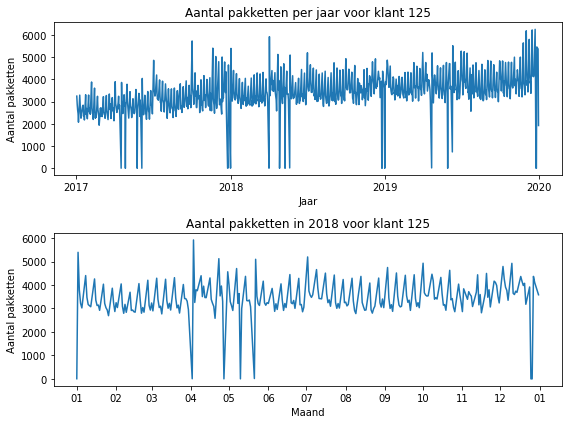

In [38]:
# Define sublots
fig, (full, year_2018) = plt.subplots(2, figsize=(8,6))

# Plot whole timeline
x = data['procesdag']
y = data['aantal_pakketten']
full.plot(x, y)
full.xaxis.set_major_formatter(DateFormatter('%Y'))
full.xaxis.set_major_locator(dates.YearLocator())
full.set(
    xlabel='Jaar',
    ylabel='Aantal pakketten',
    title='Aantal pakketten per jaar voor klant 125')

# Plot 2018
plt_2018_filter = data['procesdag'].dt.year == 2018
data_2018 = data.where(plt_2018_filter).dropna()
x2 = data_2018['procesdag']
y2 = data_2018['aantal_pakketten']
year_2018.plot(x2, y2)
year_2018.xaxis.set_major_formatter(DateFormatter('%m'))
year_2018.xaxis.set_major_locator(dates.MonthLocator())
year_2018.set(
    xlabel='Maand',
    ylabel='Aantal pakketten',
    title='Aantal pakketten in 2018 voor klant 125')

fig.tight_layout()

<h2>Jaar distributie</h2>

In [39]:
# Data for each year
data_2017 = data.where(data['procesdag'].dt.year == 2017).dropna()
data_2018 = data.where(data['procesdag'].dt.year == 2018).dropna()
data_2019 = data.where(data['procesdag'].dt.year == 2019).dropna()

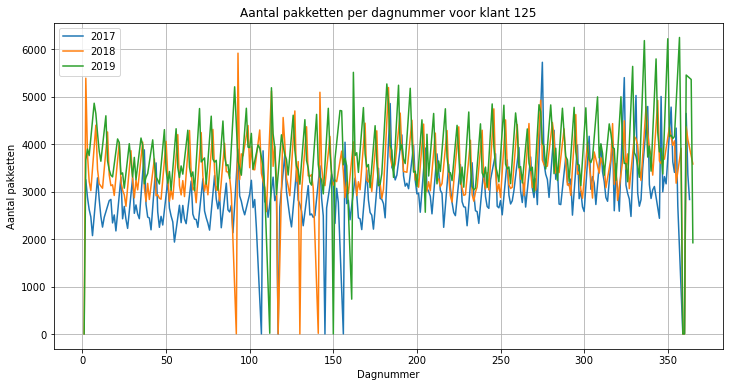

In [40]:
# Define sublots
fig, ax = plt.subplots( figsize=(12,6))

ax.plot(data_2017['procesdag'].dt.dayofyear, data_2017['aantal_pakketten'], label='2017')
ax.plot(data_2018['procesdag'].dt.dayofyear, data_2018['aantal_pakketten'], label='2018')
ax.plot(data_2019['procesdag'].dt.dayofyear, data_2019['aantal_pakketten'], label='2019')
ax.grid()
ax.set(
    xlabel='Dagnummer',
    ylabel='Aantal pakketten',
    title='Aantal pakketten per dagnummer voor klant 125')

plt.legend()
plt.show()

<a name="voorspelling"></a>
<h1>2. Voorspelling</h1>

Voor het voorspellen van het aantal pakketten (in dit notebook), maak ik gebruik van *exponential smoothing*. Je hebt 3 soorten:

- Single Exponential Smoothing
- Double Exponential Smoothing
- Triple Exponential Smoothing

Daarnaast kunnen de onderstaande onderwerpen worden behandeld:
- Feature extraction
- Correlatie matrix

In [41]:
data

,procesdag,cust_id,aantal_pakketten,aantal_pakketten_volgende_dag,validation_column
0,2017-01-02,klant_125,3245.0,2878.0,train
1,2017-01-03,klant_125,2878.0,2625.0,train
2,2017-01-04,klant_125,2625.0,2468.0,train
3,2017-01-05,klant_125,2468.0,2073.0,train
4,2017-01-06,klant_125,2073.0,0.0,train
...,...,...,...,...,...
777,2019-12-25,klant_125,0.0,0.0,validation
778,2019-12-26,klant_125,0.0,5458.0,validation
779,2019-12-27,klant_125,5458.0,0.0,validation
780,2019-12-30,klant_125,5365.0,1923.0,validation


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1094 entries, 2017-01-02 to 2019-12-31
Freq: D
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   aantal_pakketten  782 non-null    float64
dtypes: float64(1)
memory usage: 17.1 KB
None
<Day>


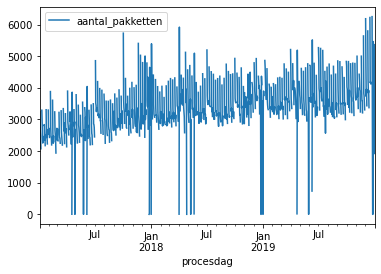

In [42]:
# Data manipulation
model_data = data[['procesdag', 'aantal_pakketten']].set_index('procesdag')
model_data = model_data.asfreq('d')
print(model_data.info())
print(model_data.index.freq)
model_data.plot()

(729, 1) (365, 1)


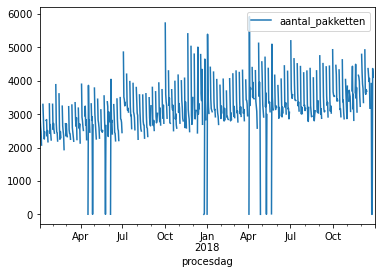

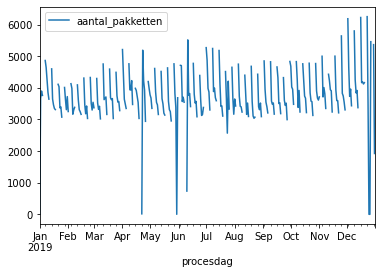

In [43]:
# Define Train and Test
train = model_data.loc['2017-01-02':'2018-12-31'] 
test = model_data.loc['2019-01-01':'2019-12-31']
print(train.shape, test.shape)
train.plot()
test.plot()